In [6]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
import matplotlib.pyplot as plt
import zipfile
import seaborn as sns
import joblib
import pickle
import os


from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix, classification_report


In [7]:
# 1. Load Data
zip_path = r"C:\Users\USER\Downloads\wine+quality.zip"

with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.printdir()
    #zip_ref.extractall("Datasets")

    with zipfile.ZipFile(zip_path) as z:
        with z.open('winequality-white.csv') as f:
            white_wine = pd.read_csv(f,sep = ";")
            white_wine.head()
            df = white_wine.copy()

File Name                                             Modified             Size
winequality-red.csv                            2023-05-22 22:24:00        84199
winequality-white.csv                          2023-05-22 22:24:00       264426
winequality.names                              2023-05-22 22:24:00         3305


In [8]:
# first six rows
df.head(6)

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.0,0.27,0.36,20.7,0.045,45.0,170.0,1.0010,3.00,0.45,8.8,6
1,6.3,0.30,0.34,1.6,0.049,14.0,132.0,0.9940,3.30,0.49,9.5,6
2,8.1,0.28,0.40,6.9,0.050,30.0,97.0,0.9951,3.26,0.44,10.1,6
3,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.9956,3.19,0.40,9.9,6
4,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.9956,3.19,0.40,9.9,6
5,8.1,0.28,0.40,6.9,0.050,30.0,97.0,0.9951,3.26,0.44,10.1,6


In [9]:
print(f"Rows: {df.shape[0]:,}")
print(f"Columns: {df.shape[1]}")
print("dataset shape:", df.shape[0], "by", df.shape[1])

Rows: 4,898
Columns: 12
dataset shape: 4898 by 12


In [10]:
df.isna().sum()

fixed acidity           0
volatile acidity        0
citric acid             0
residual sugar          0
chlorides               0
free sulfur dioxide     0
total sulfur dioxide    0
density                 0
pH                      0
sulphates               0
alcohol                 0
quality                 0
dtype: int64

In [11]:
df.duplicated().sum(axis=0)

np.int64(937)

In [12]:
# drop the duplicate 
df = df.drop_duplicates()

In [13]:
# check again to see if it clean
df.duplicated().sum(axis=0)

np.int64(0)

In [14]:
df.dtypes

fixed acidity           float64
volatile acidity        float64
citric acid             float64
residual sugar          float64
chlorides               float64
free sulfur dioxide     float64
total sulfur dioxide    float64
density                 float64
pH                      float64
sulphates               float64
alcohol                 float64
quality                   int64
dtype: object

Summary

The shape of the dataset is 4898 by 12, which means we have 12 features and 4898 instance or record. There is no missing value in the dataset. There is 937 duplicates in the dataset. so i drop it to make the data clean. so after dropping no duplicate.

2. Exploratory Data Analysis and scaling

In [15]:
# To see the desciptive statistics of the dataset
df.describe().T

,count,mean,std,min,25%,50%,75%,max
fixed acidity,3961.0,6.839346,0.866860,3.80000,6.30000,6.8000,7.30000,14.20000
volatile acidity,3961.0,0.280538,0.103437,0.08000,0.21000,0.2600,0.33000,1.10000
citric acid,3961.0,0.334332,0.122446,0.00000,0.27000,0.3200,0.39000,1.66000
residual sugar,3961.0,5.914819,4.861646,0.60000,1.60000,4.7000,8.90000,65.80000
chlorides,3961.0,0.045905,0.023103,0.00900,0.03500,0.0420,0.05000,0.34600
free sulfur dioxide,3961.0,34.889169,17.210021,2.00000,23.00000,33.0000,45.00000,289.00000
total sulfur dioxide,3961.0,137.193512,43.129065,9.00000,106.00000,133.0000,166.00000,440.00000
density,3961.0,0.993790,0.002905,0.98711,0.99162,0.9935,0.99571,1.03898
pH,3961.0,3.195458,0.151546,2.72000,3.09000,3.1800,3.29000,3.82000
sulphates,3961.0,0.490351,0.113523,0.22000,0.41000,0.4800,0.55000,1.08000


In [16]:
def univariate_numerical_eda(df, column, save_folder="EDA_Charts"):
    """
    Performs univariate EDA on a single numerical column.
    Includes:
    - Summary statistics
    - Skewness, Kurtosis
    - Outlier detection (IQR-based)
    - Histogram + Boxplot
    - Saves each figure automatically to a folder
    """

    # Create folder if it doesn’t exist
    if not os.path.exists(save_folder):
        os.makedirs(save_folder)

    print(f"\nFeature: {column}")
    print("="*60)
    print(df[column].describe().to_frame())

    
    # ====== PLOTS ======
    fig, axes = plt.subplots(1, 2, figsize=(12, 4))

    # Histogram + KDE
    sns.histplot(df[column], kde=True, bins=30, color='salmon', ax=axes[0])
    axes[0].set_title(f'Distribution of {column}')
    axes[0].set_xlabel(column)
    axes[0].set_ylabel('Frequency')

    # Boxplot
    sns.boxplot(x=df[column], color='seagreen', ax=axes[1])
    axes[1].set_title(f'Boxplot of {column}')
    axes[1].set_xlabel(column)

    plt.tight_layout()

    # Save the combined figure
    save_path = os.path.join(save_folder, f"{column}_univariate_plot.png")
    plt.savefig(save_path, bbox_inches='tight', dpi=300)
    print(f" Saved plot for '{column}' → {save_path}")

    plt.show()
    plt.close(fig)



Feature: fixed acidity
       fixed acidity
count    3961.000000
mean        6.839346
std         0.866860
min         3.800000
25%         6.300000
50%         6.800000
75%         7.300000
max        14.200000
 Saved plot for 'fixed acidity' → EDA_Charts\fixed acidity_univariate_plot.png


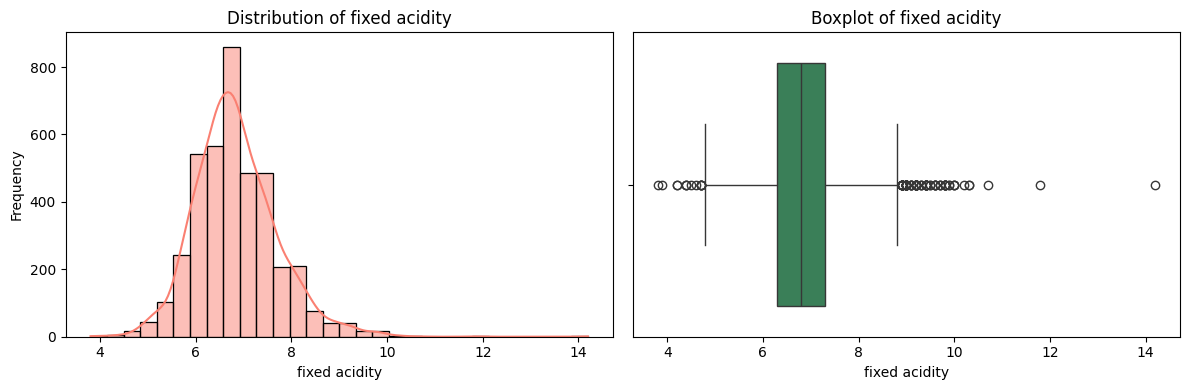


Feature: volatile acidity
       volatile acidity
count       3961.000000
mean           0.280538
std            0.103437
min            0.080000
25%            0.210000
50%            0.260000
75%            0.330000
max            1.100000
 Saved plot for 'volatile acidity' → EDA_Charts\volatile acidity_univariate_plot.png


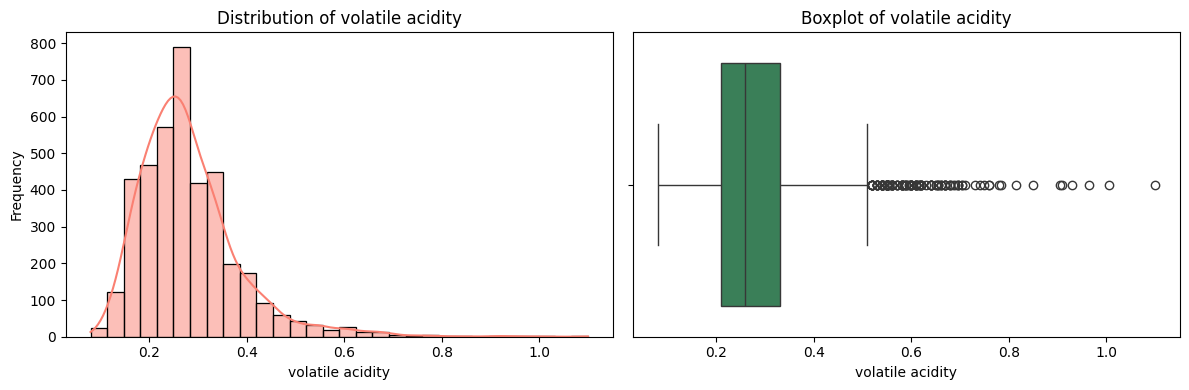


Feature: citric acid
       citric acid
count  3961.000000
mean      0.334332
std       0.122446
min       0.000000
25%       0.270000
50%       0.320000
75%       0.390000
max       1.660000
 Saved plot for 'citric acid' → EDA_Charts\citric acid_univariate_plot.png


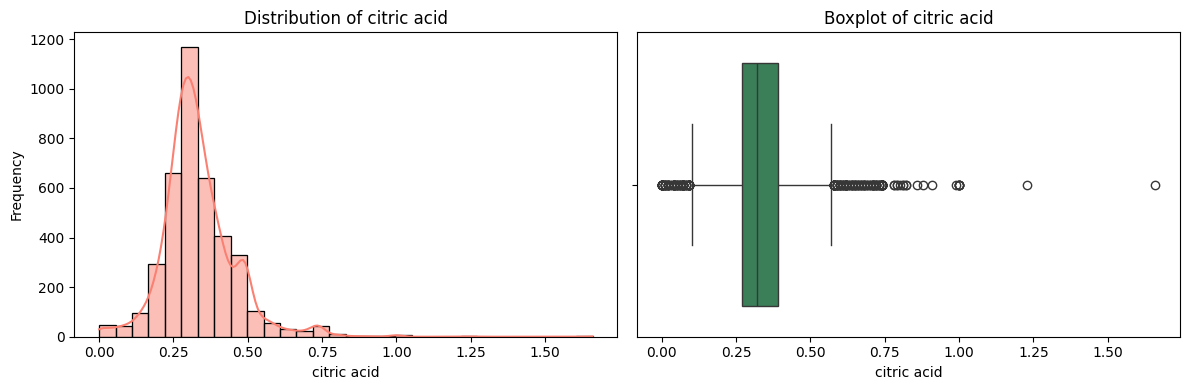


Feature: residual sugar
       residual sugar
count     3961.000000
mean         5.914819
std          4.861646
min          0.600000
25%          1.600000
50%          4.700000
75%          8.900000
max         65.800000
 Saved plot for 'residual sugar' → EDA_Charts\residual sugar_univariate_plot.png


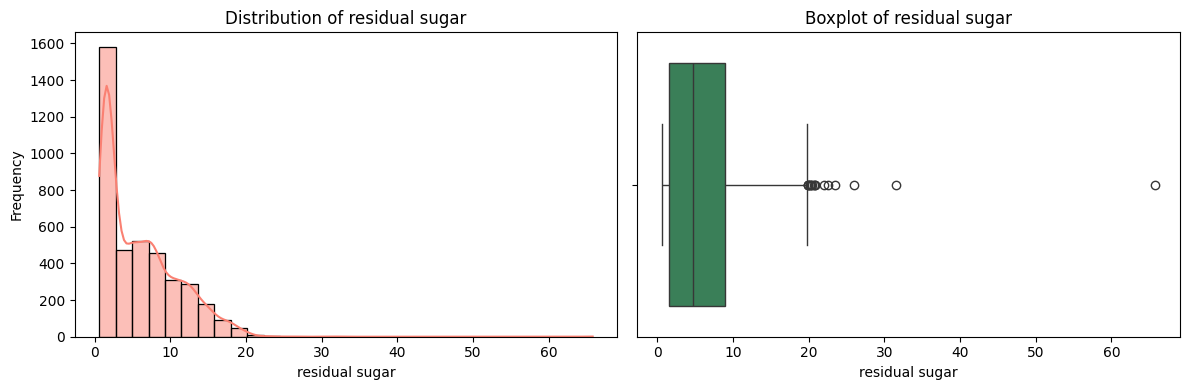


Feature: chlorides
         chlorides
count  3961.000000
mean      0.045905
std       0.023103
min       0.009000
25%       0.035000
50%       0.042000
75%       0.050000
max       0.346000
 Saved plot for 'chlorides' → EDA_Charts\chlorides_univariate_plot.png


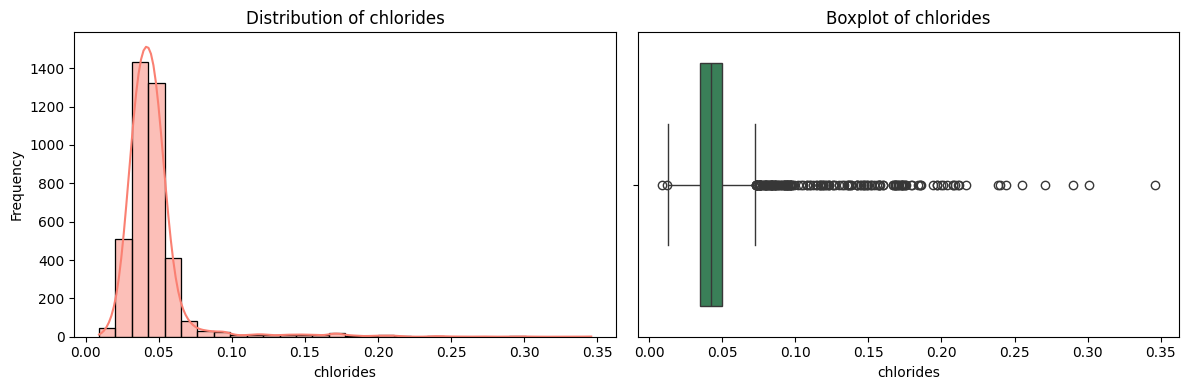


Feature: free sulfur dioxide
       free sulfur dioxide
count          3961.000000
mean             34.889169
std              17.210021
min               2.000000
25%              23.000000
50%              33.000000
75%              45.000000
max             289.000000
 Saved plot for 'free sulfur dioxide' → EDA_Charts\free sulfur dioxide_univariate_plot.png


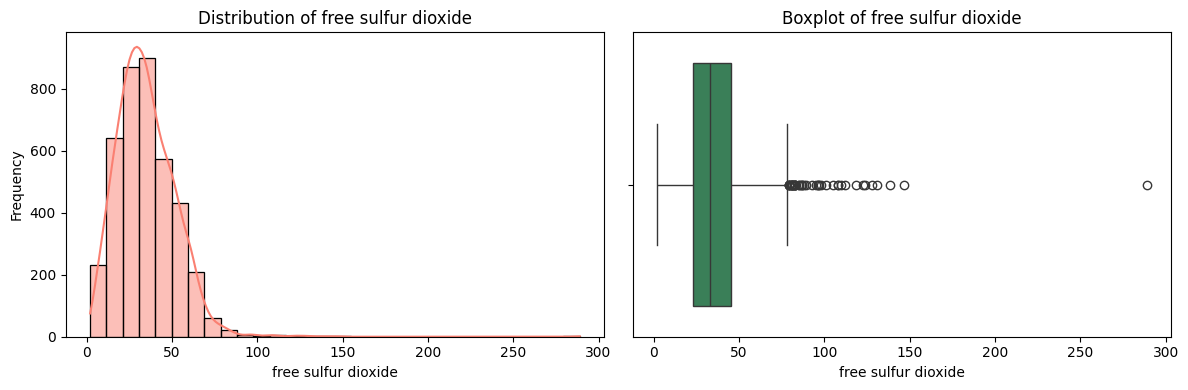


Feature: density
           density
count  3961.000000
mean      0.993790
std       0.002905
min       0.987110
25%       0.991620
50%       0.993500
75%       0.995710
max       1.038980
 Saved plot for 'density' → EDA_Charts\density_univariate_plot.png


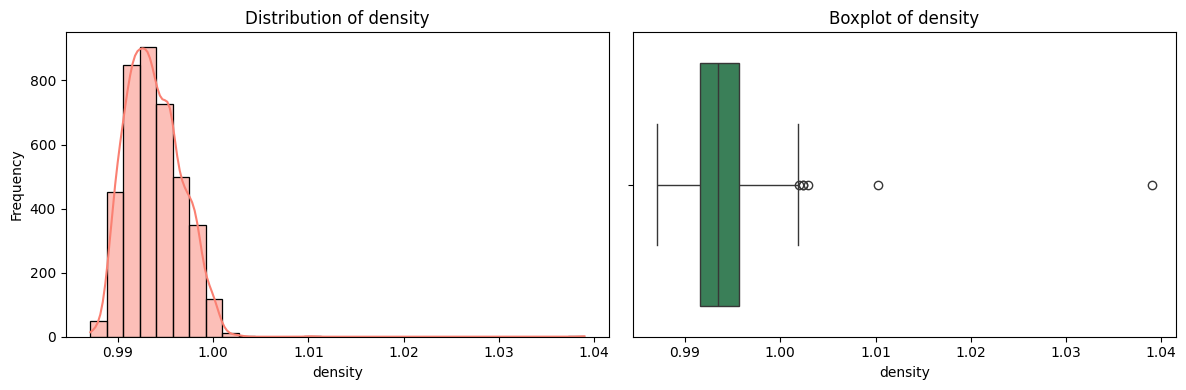


Feature: pH
                pH
count  3961.000000
mean      3.195458
std       0.151546
min       2.720000
25%       3.090000
50%       3.180000
75%       3.290000
max       3.820000
 Saved plot for 'pH' → EDA_Charts\pH_univariate_plot.png


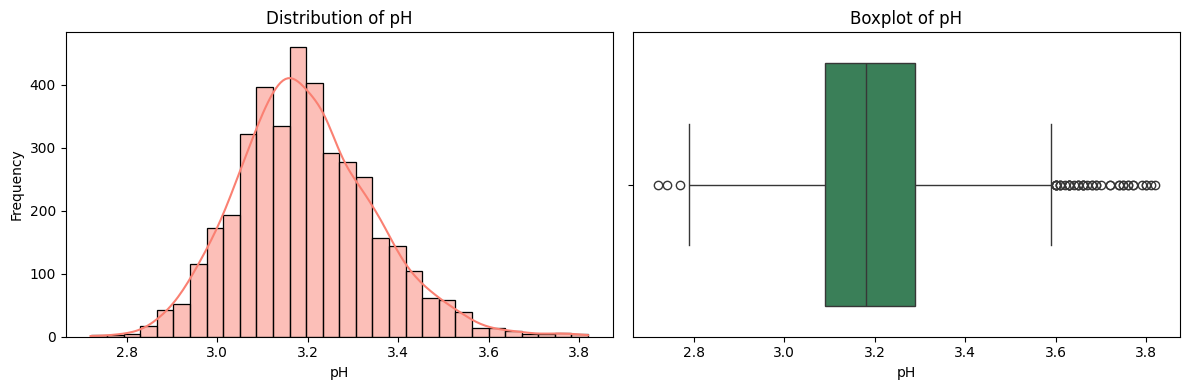


Feature: sulphates
         sulphates
count  3961.000000
mean      0.490351
std       0.113523
min       0.220000
25%       0.410000
50%       0.480000
75%       0.550000
max       1.080000
 Saved plot for 'sulphates' → EDA_Charts\sulphates_univariate_plot.png


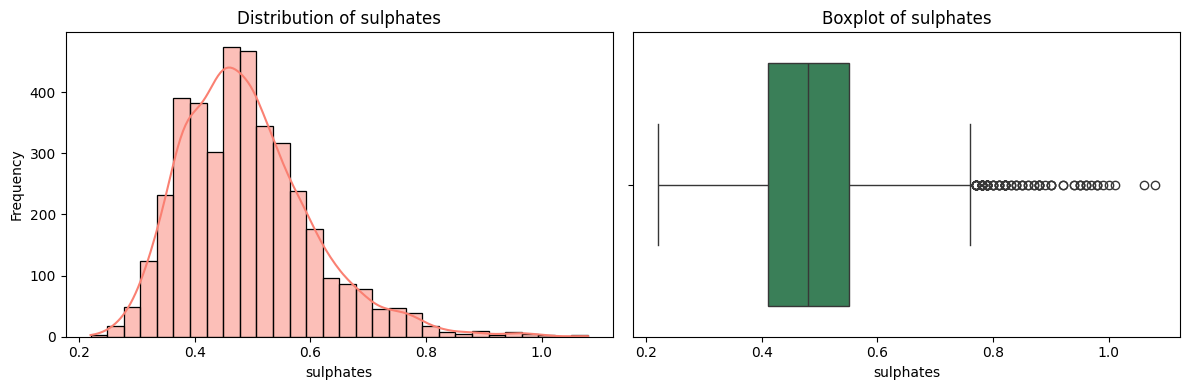


Feature: alcohol
           alcohol
count  3961.000000
mean     10.589358
std       1.217076
min       8.000000
25%       9.500000
50%      10.400000
75%      11.400000
max      14.200000
 Saved plot for 'alcohol' → EDA_Charts\alcohol_univariate_plot.png


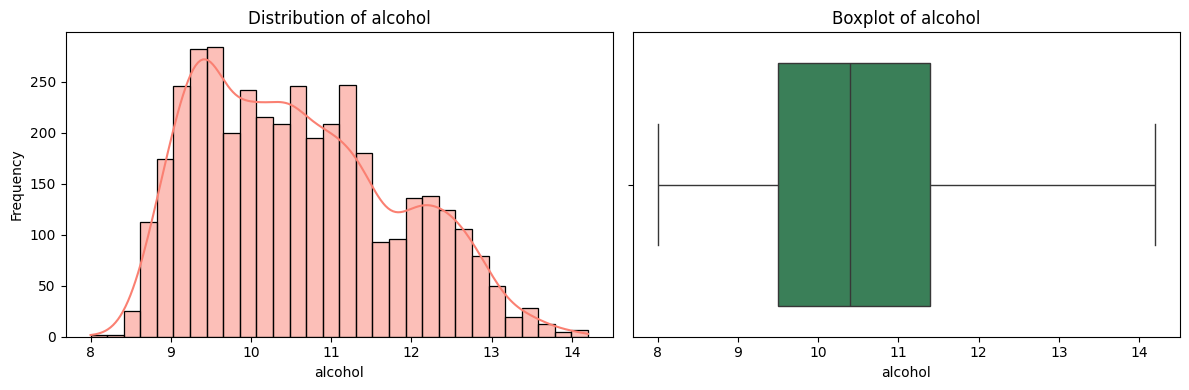

In [17]:
univariate_numerical_eda(df, 'fixed acidity')
univariate_numerical_eda(df, 'volatile acidity')
univariate_numerical_eda(df, 'citric acid')
univariate_numerical_eda(df, 'residual sugar')
univariate_numerical_eda(df, 'chlorides')
univariate_numerical_eda(df, 'free sulfur dioxide')
univariate_numerical_eda(df, 'density' )
univariate_numerical_eda(df, 'pH')
univariate_numerical_eda(df, 'sulphates')
univariate_numerical_eda(df, 'alcohol')




In [18]:
#map quality scores to labels
df['quality_label'] = df['quality'].map({9:"Best", 8:"Best", 7:"Good", 6:"Good", 5:"Average", 4:"Bad", 3: "Bad"})

In [19]:
df.drop(columns=['quality_label'], inplace=True)

X = df.drop("quality", axis=1)
y = df["quality"]


# 2. Split the data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1, stratify=y)


In [20]:
scaler = MinMaxScaler()
X_train_s = scaler.fit_transform(X_train)
X_test_s = scaler.transform(X_test)


In [21]:
print("Shape of Training set : ", X_train.shape)
print("Shape of test set : ", X_test.shape)
print("Percentage of classes in training set:")
print(y_train.value_counts(normalize=True))
print("Percentage of classes in test set:")
print(y_test.value_counts(normalize=True))

Shape of Training set :  (3168, 11)
Shape of test set :  (793, 11)
Percentage of classes in training set:
quality
6    0.451389
5    0.296717
7    0.173927
4    0.038510
8    0.033144
3    0.005051
9    0.001263
Name: proportion, dtype: float64
Percentage of classes in test set:
quality
6    0.451450
5    0.296343
7    0.174023
4    0.039092
8    0.032787
3    0.005044
9    0.001261
Name: proportion, dtype: float64


In [22]:
models = {
    "Logistic Regression": LogisticRegression()
}

for name, model in models.items():

    model.fit(X_train_s, y_train)
    
  
    y_pred = model.predict(X_test_s)
    
    accuracy = model.score(X_test_s, y_test)
    precision = precision_score(y_test, y_pred, average='weighted', zero_division=1)
    recall = recall_score(y_test, y_pred, average='weighted', zero_division=1)
    f1 = f1_score(y_test, y_pred, average='weighted', zero_division=1)
    conf_matrix = confusion_matrix(y_test, y_pred)

    print(f"{name} Accuracy: {accuracy:.4f}")
    print(f"{name} Precision: {precision:.4f}")
    print(f"{name} Recall: {recall:.4f}")
    print(f"{name} F1 Score: {f1:.4f}")
    print(f"{name} Confusion Matrix:\n{conf_matrix}")
    print(f"{name} Classification Report:\n{classification_report(y_test, y_pred)}")
    print("-" * 60)


Logistic Regression Accuracy: 0.5410
Logistic Regression Precision: 0.5855
Logistic Regression Recall: 0.5410
Logistic Regression F1 Score: 0.4981
Logistic Regression Confusion Matrix:
[[  0   0   3   1   0   0   0]
 [  0   0  17  14   0   0   0]
 [  0   0 117 116   2   0   0]
 [  0   0  62 281  15   0   0]
 [  0   0   7 100  31   0   0]
 [  0   0   1  20   5   0   0]
 [  0   0   0   1   0   0   0]]
Logistic Regression Classification Report:
              precision    recall  f1-score   support

           3       0.00      0.00      0.00         4
           4       0.00      0.00      0.00        31
           5       0.57      0.50      0.53       235
           6       0.53      0.78      0.63       358
           7       0.58      0.22      0.32       138
           8       0.00      0.00      0.00        26
           9       0.00      0.00      0.00         1

    accuracy                           0.54       793
   macro avg       0.24      0.22      0.21       793
weighted avg

C:\Users\USER\AppData\Roaming\Python\Python313\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\USER\AppData\Roaming\Python\Python313\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\USER\AppData\Roaming\Python\Python313\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is",

Build  and compare Multiple models

C:\Users\USER\AppData\Roaming\Python\Python313\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\USER\AppData\Roaming\Python\Python313\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\USER\AppData\Roaming\Python\Python313\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is",


=== RANDOM FOREST ===
              precision    recall  f1-score   support

           3       0.00      0.00      0.00         4
           4       0.67      0.13      0.22        31
           5       0.60      0.57      0.58       235
           6       0.56      0.74      0.64       358
           7       0.55      0.35      0.43       138
           8       0.50      0.04      0.07        26
           9       0.00      0.00      0.00         1

    accuracy                           0.57       793
   macro avg       0.41      0.26      0.28       793
weighted avg       0.57      0.57      0.54       793



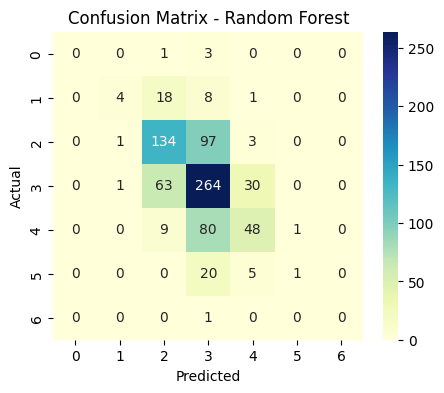

C:\Users\USER\AppData\Roaming\Python\Python313\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\USER\AppData\Roaming\Python\Python313\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\USER\AppData\Roaming\Python\Python313\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is",


=== K-NEAREST NEIGHBORS ===
              precision    recall  f1-score   support

           3       0.00      0.00      0.00         4
           4       0.08      0.03      0.05        31
           5       0.40      0.46      0.43       235
           6       0.49      0.58      0.53       358
           7       0.31      0.20      0.25       138
           8       0.00      0.00      0.00        26
           9       0.00      0.00      0.00         1

    accuracy                           0.43       793
   macro avg       0.18      0.18      0.18       793
weighted avg       0.40      0.43      0.41       793



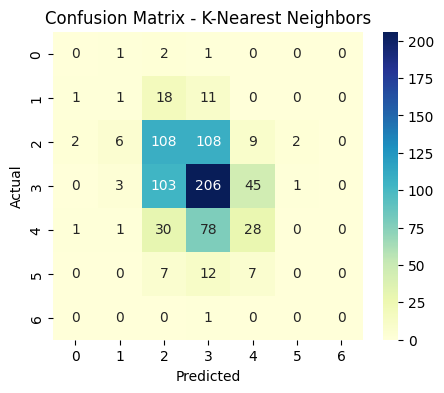


=== GRADIENT BOOSTING ===
              precision    recall  f1-score   support

           3       0.00      0.00      0.00         4
           4       0.43      0.29      0.35        31
           5       0.58      0.52      0.55       235
           6       0.55      0.70      0.62       358
           7       0.43      0.28      0.34       138
           8       0.20      0.04      0.06        26
           9       0.00      0.00      0.00         1

    accuracy                           0.53       793
   macro avg       0.31      0.26      0.27       793
weighted avg       0.52      0.53      0.52       793



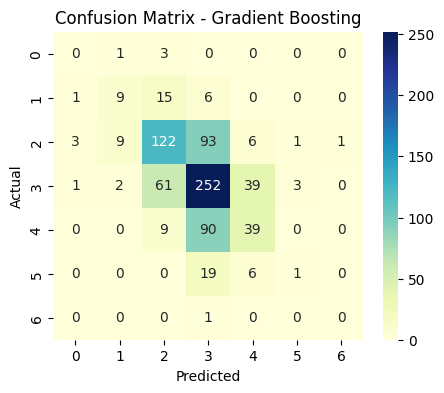

C:\Users\USER\AppData\Roaming\Python\Python313\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\USER\AppData\Roaming\Python\Python313\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\USER\AppData\Roaming\Python\Python313\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is",


=== SUPPORT VECTOR MACHINE ===
              precision    recall  f1-score   support

           3       0.00      0.00      0.00         4
           4       0.00      0.00      0.00        31
           5       0.35      0.03      0.05       235
           6       0.45      0.97      0.61       358
           7       0.00      0.00      0.00       138
           8       0.00      0.00      0.00        26
           9       0.00      0.00      0.00         1

    accuracy                           0.45       793
   macro avg       0.11      0.14      0.10       793
weighted avg       0.31      0.45      0.29       793



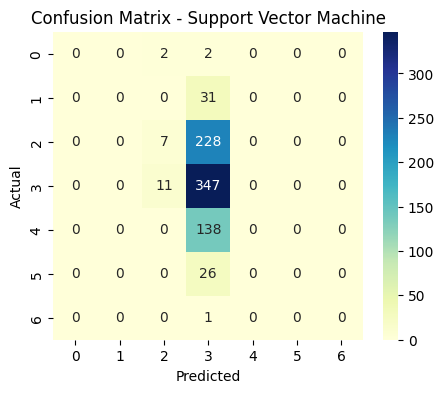


=== MODEL PERFORMANCE COMPARISON ===
                    Model  Accuracy  Precision    Recall  F1-score
0           Random Forest  0.568726   0.566928  0.568726  0.544538
2       Gradient Boosting  0.533417   0.517662  0.533417  0.515486
1     K-Nearest Neighbors  0.432535   0.400447  0.432535  0.412002
3  Support Vector Machine  0.446406   0.306376  0.446406  0.293287

 Best Performing Model: Random Forest

INTERPRETATION:
- Accuracy shows overall correctness.
- Precision shows how reliable the positive predictions are.
- Recall shows how well the model identifies actual positives.
- F1-score balances Precision and Recall.
The model with the highest F1-score generally provides the best trade-off between these metrics.



In [23]:
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
# --- Initialize models ---
models = {
    "Random Forest": RandomForestClassifier(random_state=42),
    "K-Nearest Neighbors": KNeighborsClassifier(),
    "Gradient Boosting": GradientBoostingClassifier(random_state=42),
    "Support Vector Machine": SVC(kernel='rbf', random_state=42)
}
# --- Evaluate each model ---
results = []
for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    acc = accuracy_score(y_test, y_pred)
    prec = precision_score(y_test, y_pred, average='weighted')
    rec = recall_score(y_test, y_pred, average='weighted')
    f1 = f1_score(y_test, y_pred, average='weighted')
    results.append({
        "Model": name,
        "Accuracy": acc,
        "Precision": prec,
        "Recall": rec,
        "F1-score": f1
    })
    print(f"\n=== {name.upper()} ===")
    print(classification_report(y_test, y_pred))
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(5, 4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='YlGnBu')
    plt.title(f'Confusion Matrix - {name}')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()
# --- Create comparison DataFrame ---
comparison_df = pd.DataFrame(results)
comparison_df = comparison_df.sort_values(by="F1-score", ascending=False)
print("\n=== MODEL PERFORMANCE COMPARISON ===")
print(comparison_df)
# --- Identify best model ---
best_model_name = comparison_df.iloc[0]["Model"]
print(f"\n Best Performing Model: {best_model_name}")
# --- INTERPRETATION ---
print("""
INTERPRETATION:
- Accuracy shows overall correctness.
- Precision shows how reliable the positive predictions are.
- Recall shows how well the model identifies actual positives.
- F1-score balances Precision and Recall.
The model with the highest F1-score generally provides the best trade-off between these metrics.
""")


Best model selected for tuning: Random Forest
Fitting 5 folds for each of 20 candidates, totalling 100 fits


C:\Users\USER\AppData\Roaming\Python\Python313\site-packages\sklearn\model_selection\_split.py:805: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(



=== BEST PARAMETERS FOUND ===
{'n_estimators': 100, 'min_samples_split': 5, 'min_samples_leaf': 1, 'max_depth': 30, 'bootstrap': False}

=== OPTIMIZED MODEL PERFORMANCE ===
Accuracy:  0.5637
Precision: 0.5443
Recall:    0.5637
F1-score:  0.5426

Classification Report:
               precision    recall  f1-score   support

           3       0.00      0.00      0.00         4
           4       0.64      0.23      0.33        31
           5       0.60      0.57      0.58       235
           6       0.55      0.72      0.62       358
           7       0.53      0.36      0.43       138
           8       0.00      0.00      0.00        26
           9       0.00      0.00      0.00         1

    accuracy                           0.56       793
   macro avg       0.33      0.27      0.28       793
weighted avg       0.54      0.56      0.54       793



C:\Users\USER\AppData\Roaming\Python\Python313\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\USER\AppData\Roaming\Python\Python313\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\USER\AppData\Roaming\Python\Python313\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is",

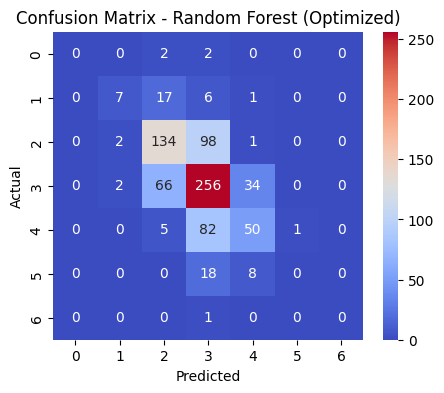


Interpretation:
If the optimized model’s F1-score and Recall improved compared to the baseline,
it indicates that hyperparameter tuning helped the model generalize better.
If there’s little to no improvement, it may suggest that the base configuration
was already near optimal or that the data is not highly sensitive to those parameters.



In [24]:
# === MODEL OPTIMIZATION USING RANDOMIZED SEARCH ===
# Select best model from previous comparison
best_model_name = comparison_df.iloc[0]["Model"]
print(f"Best model selected for tuning: {best_model_name}")
# Define parameter grids for each model type
param_grids = {
    "Random Forest": {
        'n_estimators': [100, 200, 300, 400, 500],
        'max_depth': [None, 10, 20, 30, 40, 50],
        'min_samples_split': [2, 5, 10],
        'min_samples_leaf': [1, 2, 4],
        'bootstrap': [True, False]
    },
    "Gradient Boosting": {
        'n_estimators': [100, 200, 300],
        'learning_rate': [0.01, 0.05, 0.1, 0.2],
        'max_depth': [3, 4, 5, 6],
        'subsample': [0.8, 0.9, 1.0]
    },
    "K-Nearest Neighbors": {
        'n_neighbors': [3, 5, 7, 9, 11],
        'weights': ['uniform', 'distance'],
        'metric': ['minkowski', 'euclidean', 'manhattan']
    },
    "Support Vector Machine": {
        'C': [0.1, 1, 10, 100],
        'gamma': ['scale', 'auto'],
        'kernel': ['linear', 'rbf', 'poly']
    }
}
# Get the model object from your models dictionary
model_to_tune = models[best_model_name]
param_dist = param_grids[best_model_name]
# Perform Randomized Search
random_search = RandomizedSearchCV(
    estimator=model_to_tune,
    param_distributions=param_dist,
    n_iter=20,
    scoring='f1_weighted',
    cv=5,
    verbose=2,
    random_state=42,
    n_jobs=-1
)
random_search.fit(X_train, y_train)
best_params = random_search.best_params_
print("\n=== BEST PARAMETERS FOUND ===")
print(best_params)
# Retrain the best model with optimal hyperparameters
optimized_model = random_search.best_estimator_
y_pred_opt = optimized_model.predict(X_test)
# Re-evaluate performance
acc = accuracy_score(y_test, y_pred_opt)
prec = precision_score(y_test, y_pred_opt, average='weighted')
rec = recall_score(y_test, y_pred_opt, average='weighted')
f1 = f1_score(y_test, y_pred_opt, average='weighted')
print("\n=== OPTIMIZED MODEL PERFORMANCE ===")
print(f"Accuracy:  {acc:.4f}")
print(f"Precision: {prec:.4f}")
print(f"Recall:    {rec:.4f}")
print(f"F1-score:  {f1:.4f}")
print("\nClassification Report:\n", classification_report(y_test, y_pred_opt))
# Confusion matrix
cm = confusion_matrix(y_test, y_pred_opt)
plt.figure(figsize=(5, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='coolwarm')
plt.title(f'Confusion Matrix - {best_model_name} (Optimized)')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()


print("""
Interpretation:
If the optimized model’s F1-score and Recall improved compared to the baseline,
it indicates that hyperparameter tuning helped the model generalize better.
If there’s little to no improvement, it may suggest that the base configuration
was already near optimal or that the data is not highly sensitive to those parameters.
""")

In [25]:
# === SAVE MODEL AND SCALER ===
# Save the optimized model
joblib.dump(optimized_model, 'model.pkl')
print(" Optimized model saved successfully as 'model.pkl'")
# Save the scaler (assuming your scaler variable is named 'scaler')
joblib.dump(scaler, 'scaler.pkl')
print(" Scaler saved successfully as 'scaler.pkl'")
print("\nBoth files (model.pkl and scaler.pkl) are ready for deployment.")

 Optimized model saved successfully as 'model.pkl'
 Scaler saved successfully as 'scaler.pkl'

Both files (model.pkl and scaler.pkl) are ready for deployment.
